# Dinosaur Name Generation

Generating dinosaur names using a character-level language model with RNNs.

_PyTorch implementation of the assignment of Course 5 of Coursera's Deep Learning Specialization_.

## Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset

## Reproducibility

In [2]:
seed = 24
random.seed(seed)
torch.manual_seed(seed);

## Device Configuration

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset

We will create a custom dataset that will provide the following:

- Each sample is each **character** of a dinosaur name
- Each corresponding target is a **character** of the same name, shifted one to the right
  - We shift the characters because we want to predict the next most likely character given some previous character
- 1536 training examples
- 19909 total characters
- 28 unique characters in our vocabulary (a-z, the terminal `\n` character and a special `<PAD>` character)

We will also define two mappings to track character-to-index and index-to-character values of our vocabulary. This will help us build the training set (using indices) and sample new names (using characters).

In [4]:
data = open('data/dinos.txt', 'r').read()
data = data.lower()
chars = sorted(list(set(data)))
# Add the <PAD> character
chars.append('<PAD>')

char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

In [5]:
class DinosaurNamesDataset(Dataset):
    def __init__(self):
        with open('data/dinos.txt', 'r') as f:
            self.dataset = [x.lower().strip() for x in f.readlines()]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Generate the training examples with the indices for each character
        X = [char_to_ix[ch] for ch in self.dataset[idx]]
        # Generate the target by shifting the values (i.e. start from index 1 instead of 0) and adding the terminal
        y = X[1:] + [char_to_ix['\n']]

        return torch.tensor(X), torch.tensor(y)


def pad(batch):
    # Pads the sequences in a batch so they can all have the same length and thus be used in a `DataLoader`
    # Based on https://stackoverflow.com/a/57207895
    # Ref 1: https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
    # Ref 2: https://pytorch.org/tutorials/beginner/chatbot_tutorial.html#prepare-data-for-models
    X = [x for (x, _) in batch]
    y = [y for (_, y) in batch]
    
    # Compute the lengths of the samples' sequences before padding, needed for packing them all later
    X_lengths = [x.shape[0] for (x, _) in batch]

    # Pad sequences to make them the same length
    pad_value = char_to_ix['<PAD>']
    X = rnn_utils.pad_sequence(X, batch_first=True, padding_value=pad_value)
    y = rnn_utils.pad_sequence(y, batch_first=True, padding_value=pad_value)
    
    # Compute the masks for the targets, needed for masking out the loss computation later
    mask = y != pad_value

    return X, y, X_lengths, mask

We can now create our training set.

In [6]:
# The `collate_fn` applies a transformation to the batch
training = DataLoader(DinosaurNamesDataset(), batch_size=64, shuffle=True, num_workers=4, collate_fn=pad)

## Model

We'll use a vanilla Recurrent Neural Network with a **single** recurrent layer with **50 units**, and a **softmax** output function at _each_ RNN cell. This means our model expects $T_x = T_y$, i.e. the length of the input sequence should match the length of the target sequence. The reason is that we are generating a character-level model using the _same_ name as both input and target (shifted).

For the input, the model will one-hot encode the character indices based on the size of our vocabulary (28 characters).

![](img/rnn.png)

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.rnn = nn.RNN(input_size=28, hidden_size=50, batch_first=True)
        # Output layer to convert to target space (28 character classes)
        self.out = nn.Linear(in_features=50, out_features=28)

    def forward(self, X, X_lengths):
        # One-hot the input
        output = F.one_hot(X, num_classes=28).float()

        # `pack_padded_sequence` so that padded items in the sequence won't be shown to the RNN
        # See: https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
        output = rnn_utils.pack_padded_sequence(output, X_lengths, batch_first=True, enforce_sorted=False)

        # Pass through RNN
        output, _ = self.rnn(output)

        # Undo the packing operation
        # See: https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e
        output, _ = rnn_utils.pad_packed_sequence(output, batch_first=True)

        # Convert to target space
        output = self.out(output)

        # Apply softmax on the vocab dimension explicitly (as opposed to using PyTorch's combined loss function) since we will be defining
        # our own custom loss function
        output = F.softmax(output, dim=2)

        return output

In [8]:
model = Model()
print(model)

Model(
  (rnn): RNN(28, 50, batch_first=True)
  (out): Linear(in_features=50, out_features=28, bias=True)
)


## Optimization

We'll use Adam for training the model with a custom cross-entropy loss. A custom loss function is needed because we don't want to consider the elements that correspond to the special character `<PAD>` in the computation.

_Note: see https://pytorch.org/tutorials/beginner/chatbot_tutorial.html#masked-loss_

In [9]:
def masked_cross_entropy_loss(output, targets, mask):
    # `torch.gather()` grabs the output activations that correspond to the "indexes" given by the targets
    # e.g. if the target is the character with index 5, then it grabs the activation at index 5
    # Once we have the activations that correspond to the targets, we can compute the negative log likelihood, i.e. the cross-entropy
    # This is equivalent to having the targets be vectors of 0's with a 1 in the corresponding index which would zero out all other computations
    cross_entropy = -torch.log(torch.gather(output.view(-1, 28), 1, targets.view(-1, 1)).squeeze(1))
    # Now mask out the padded values and reduce the losses using the average to generate the final loss for the batch
    loss = cross_entropy.masked_select(mask.view(-1, 1)).mean()

    return loss

In [10]:
loss_fn = masked_cross_entropy_loss
optimizer = optim.Adam(model.parameters())

## Training

Time to train the model!

In [11]:
# Training configuration
epochs = 35000

[0/35000]	Loss: 3.1735522747039795
[1000/35000]	Loss: 0.7182769775390625
[2000/35000]	Loss: 0.6934554576873779
[3000/35000]	Loss: 0.683504581451416
[4000/35000]	Loss: 0.6608338952064514
[5000/35000]	Loss: 0.7030109763145447
[6000/35000]	Loss: 0.6749889254570007
[7000/35000]	Loss: 0.6569188237190247
[8000/35000]	Loss: 0.6603567600250244
[9000/35000]	Loss: 0.679055392742157
[10000/35000]	Loss: 0.655177652835846
[11000/35000]	Loss: 0.6694705486297607
[12000/35000]	Loss: 0.7158105969429016
[13000/35000]	Loss: 0.680025041103363
[14000/35000]	Loss: 0.6461178660392761
[15000/35000]	Loss: 0.6865223050117493
[16000/35000]	Loss: 0.6566489338874817
[17000/35000]	Loss: 0.6718356609344482
[18000/35000]	Loss: 0.6508365869522095
[19000/35000]	Loss: 0.6647751331329346
[20000/35000]	Loss: 0.6493016481399536
[21000/35000]	Loss: 0.6633304357528687
[22000/35000]	Loss: 0.6532465815544128
[23000/35000]	Loss: 0.6576023101806641
[24000/35000]	Loss: 0.6657090783119202
[25000/35000]	Loss: 0.6511833667755127
[26

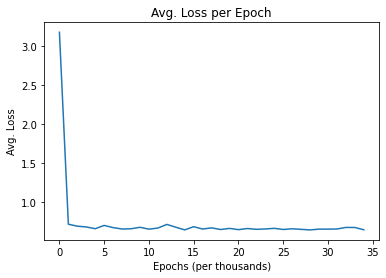

In [12]:
# Main training loop
model = model.to(device)
total_losses = []

for epoch in range(epochs):
    losses = []

    for X, y, X_lengths, mask in training:
        optimizer.zero_grad()

        X = X.to(device)
        y = y.to(device)
        mask = mask.to(device)

        output = model(X, X_lengths)

        loss = loss_fn(output, y, mask)

        loss.backward()
        
        # Clip gradients using a max value of 5 as in the Deep Learning Specialization assignment
        nn.utils.clip_grad_value_(model.parameters(), 5)

        optimizer.step()
        
        # Detach the loss to avoid saving any more computations on it
        losses.append(loss.detach().cpu().numpy())

    if epoch % 1000 == 0:
        total_losses.append(np.mean(losses))
        print(f'[{epoch}/{epochs}]\tLoss: {total_losses[-1]}')

# Save the model
torch.save(model.state_dict(), 'model/model.pt')

# Plot the losses
plt.plot(np.squeeze(total_losses))
plt.ylabel('Avg. Loss')
plt.xlabel('Epochs (per thousands)')
plt.title('Avg. Loss per Epoch')
plt.show()

## Testing

Now that we have trained our model, we can use it to sample new dinosaur names!

In [13]:
# Load the trained model
model = Model()
model.load_state_dict(torch.load('model/model.pt'))
# Always set the mode to `eval` for inference
model.eval()
model = model.to(device)

# Names to generate
num_names = 10
# Max number of characters in a name
# As mentioned in the Deep Learning Specialization assignment, this should be unlikely with a well-trained model but it's a safety measure
max_chars = 50
# The generated dinosaur names
names = []

# Main sampling loop
for _ in range(num_names):
    # Initialize the input as a sampel with value zero of size (batch_size=1, seq_len=1, 28)
    input = torch.tensor(0).unsqueeze(0).unsqueeze(1)
    name = ""
    char = ''
    chars = 0

    while char != '\n' and chars < max_chars:
        output = model(input.to(device), [1])
        output = output.detach().cpu().flatten()

        # We use PyTorch's multinomial vs NumPy's random choice because it handles probabilities that are very close to 1 (e.g. 1.000001) much better
        # See: https://discuss.pytorch.org/t/torch-equivalent-of-numpy-random-choice/16146/14
        idx = np.squeeze(output.multinomial(num_samples=1, replacement=True).numpy())

        # Save the actual character and continue building the name
        char = ix_to_char[int(idx)]
        name += char

        # The sampled character becomes the input to the next timestep
        # Make sure to add the batch_size=1 and seq_len=1 dimensions
        input = torch.tensor(idx).unsqueeze(0).unsqueeze(1)

        chars += 1

    names.append(name)

# Display all dinosaur names capitalized
for name in names:
    print(f'{name[0].upper() + name[1:]}')

Uchalillorucanorizeoraurelurutalisisthyulinabarlua
Isuriseinaledanyaraneriamalungicheosaelatinaneuaus
Amorusineomanisuchosinadrrunepravesteralalalinyali
Utralicralisusheprisiscrhinovistadesceorulumanycov
Olilantadrinquekeutanisileneonotanycaganeolaneuneo
Ueucilepelalehamaneushorisyilaliledestyuhicojustra
Unusiralalorunorigorugerisholinalutyailerucacharai
Ereosinojigorilulilasanilautrhadinodeusiseuevauapo
Oveunigwutorheraus

Odeoriyumohyaceuririneyisushoshazeomanoligistautat
